This is a work in progress, please don't use this yet! - James

Alternate way of running this could be to have a function for a generic volcano then run it for each volcano?

In [1]:
#import relevant modules
import obspy
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from obspy import read_inventory
client = Client("GEONET") #will need to be nrt-client link when live - this is for testing
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as md
from mpl_toolkits.basemap import Basemap

In [2]:
## allows user input for the date - should make this a "now" thing rather than requiring it! Could probably configure it to work out when it's Monday to automatically run the weekly test
date_text = input("Enter a date (yyyy-mm-dd): ")

Enter a date (yyyy-mm-dd):  2019-09-03


In [3]:
# converting date to UTCDateTime format - If using a NZT date the 18:00:00 bit should change as that's converting a UTC day into 6 am-6 am nzt the next day. 
starttime = date_text + " 18:00:00" 

In [4]:
#list of volcanoes
volcano_list = ["Auckland", "Kermadec Islands", "Mayor Island", "Ngauruhoe", "Northland", "Okataina", "Rotorua", "Ruapehu", "Taranaki", "Taupo", "Tongariro", "White Island"]
#Lat/long boundaries of said volcanic areas. Must retain current order or will not work - first values correspond to Auckland, second to Kermies etc. 
min_lat = [-37.17, -32.9, -37.53, -39.21, -36.03, -38.34, -38.20, -39.5, -39.67, -39.08, -39.21, -38]
max_lat = [-36.57, -24.0, -37.04, -39.08, -34.89, -37.95, -37.98, -39.18,-38.93, -38.5, -39.08,-37.34]
min_lon = [174.45, 179.5, 175.87, 175.56, 173.38, 176.32, 176.12, 175.32, 173.60, 175.56, 175.56, 176.69 ]
max_lon = [175.27, -175.8, 176.64, 175.72, 174.75, 176.81, 176.42, 175.77, 174.49, 176.24, 175.72, 177.40]
#Dataframe not currently used but keeping in case
volc_df = pd.DataFrame({"volcano_name":volcano_list, "min_lat":min_lat, "max_lat":max_lat, "min_lon":min_lon, "max_lon":max_lon})

In [5]:
def magtime(catalog, volc):
    lat, lon, mag = ([] for i in range(3))
    for a in range(len(catalog)):
        mag.append(catalog[a].preferred_magnitude().mag)
        for b in range(len(catalog[a].origins)):
            origtime.append(catalog[a].origins[b].time)
            depth.append(catalog[a].origins[b].depth)
    data_df = pd.DataFrame({"time":origtime, "magnitude":mag})
    dstr = [str(d) for d in origtime]
    pddates = [pd.to_datetime(d) for d in dstr]
    matdates = md.date2num(pddates)
    fig, ax = plt.subplots(2, 1,figsize=(10,10))
    hours = md.HourLocator(interval = 2)
    h_fmt = md.DateFormatter('%H:%M:%S')
    ax[0].plot_date(matdates, mag, c = 'r', marker = 'D', ms = 5, mew = 1, mec = 'black')
    plt.xticks(rotation=70)
    ax[0].grid(True)
    ax[0].set_ylim(ymin=1,ymax = 6)
    ax[0].xaxis.set_major_locator(hours)
    ax[0].xaxis.set_major_formatter(h_fmt)
    ax[0].set_ylabel("Magnitude")
    fig.autofmt_xdate()
    ax[1].plot_date(matdates, depth, c = 'b', marker = 'D', ms = 5, mew = 1, mec = 'black')
    plt.xticks(rotation=70)
    plt.grid(True)
    ax[1].set_ylim()
    ax[1].grid(True)
    ax[1].xaxis.set_major_locator(hours)
    ax[1].xaxis.set_major_formatter(h_fmt)
    ax[1].set_ylabel("Depth")
    plt.gca().invert_yaxis()
    fig.autofmt_xdate()
    plt.suptitle("Magnitude and depth versus time: " + volc,  fontsize = 16)
    plt.xlabel("Day starting " + date_text + " UTC") # would love to fix this to be NZT
    return plt.show()

In [6]:
def latlon(catalog):
    lat, lon, mag = ([] for i in range(3))
    for a in range(len(catalog)):
        for b in range(len(catalog[a].origins)):
            lat.append(catalog[a].origins[b].latitude)
            lon.append(catalog[a].origins[b].longitude)
            mag.append(catalog[a].preferred_magnitude().mag)
    magr = [int(str(x)[0])**2 * 5 for x in mag]
    meanlon = sum(lon) / len(lon)
    meanlat = sum(lat) / len(lat)
    fig, ax = plt.subplots(figsize = (10,10)) 
    map = Basemap(projection = 'merc', llcrnrlon = meanlon - .2, llcrnrlat = meanlat - .2 , urcrnrlon = meanlon + .2, urcrnrlat = meanlat + .2, epsg = 2193)
    map.arcgisimage(service = "World_Topo_Map", xpixels = 1000) #closes to Geonet background map
    x, y = map(lon, lat)
    scatter = ax.scatter(x,y, s = magr * 10, marker = 'o', c = 'r', edgecolors = 'black', linewidths = 0.3, alpha = 0.5)
    plt.title("map")
    return plt.show()

Auckland No earthquakes found
Mayor Island No earthquakes found
Ngauruhoe No earthquakes found
Northland No earthquakes found
Okataina No earthquakes found
Rotorua No earthquakes found
Taranaki No earthquakes found
Tongariro No earthquakes found
White Island No earthquakes found
The following volcanoes had more than 10 EQs in past 24 h: Taupo. Count: 81
The following volcanoes had more than 3 M2+ EQs in past 24 h: Taupo. Count: 30




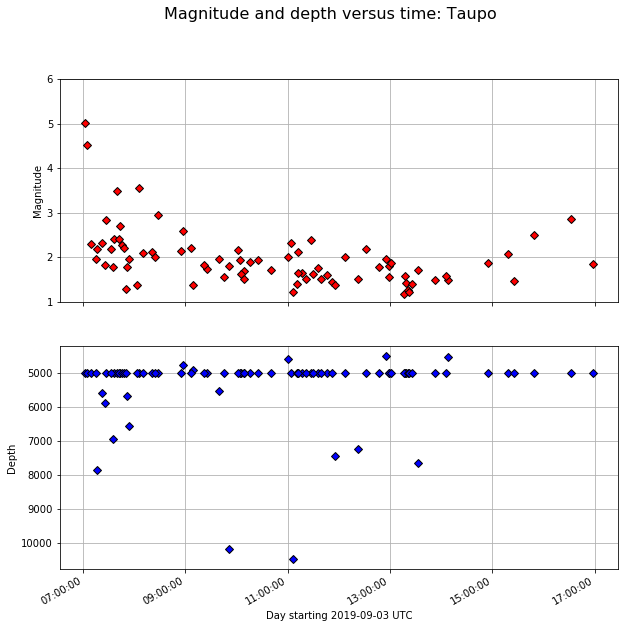

/opt/conda/envs/ngmc/lib/python3.6/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  


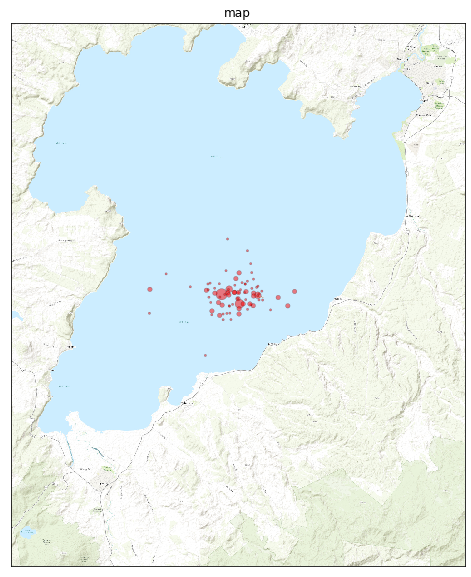

In [7]:
volc_copy = [] #needs better descriptive name. Empty list for appending.
#For loop running a obspy "get events" function to pull every even within each of the lat/long boxes, storing them as tuples of volcano + events within a larger list
for a in range(len(volcano_list)):
    try:
        volc_copy.append((volcano_list[a],client.get_events(starttime=UTCDateTime(starttime), endtime=UTCDateTime(starttime)+86400, minlatitude = min_lat[a], maxlatitude = max_lat[a], minlongitude = min_lon[a], maxlongitude = max_lon[a], maxdepth = 30)))
    except:
        print(volcano_list[a] + " No earthquakes found") #if no quakes are found this will print instead
anymag = [x for x in volc_copy if len(x[1]) > 10] #determining if there are more than 10 events within the specified time period.
nm = [] #needs better name

twoplus = []
#Below is same as the previous function but with the "minmagnitude" parameter set to 2, to restrict to only quakes larger than this.
for a in range(len(volcano_list)):
    try:
        twoplus.append((volcano_list[a],client.get_events(starttime=UTCDateTime(starttime), endtime=UTCDateTime(starttime)+86400, minlatitude = min_lat[a], maxlatitude = max_lat[a], minlongitude = min_lon[a], maxlongitude = max_lon[a], maxdepth = 30, minmagnitude = 2)))
    except:
        pass
twomag = [x for x in twoplus if len(x[1]) > 3]
for x in range(len(anymag)):
    print("The following volcanoes had more than 10 EQs in past 24 h: " + anymag[x][0] + ". Count: " + str(len(anymag[x][1]))) #delete
for x in range(len(twomag)):
    print("The following volcanoes had more than 3 M2+ EQs in past 24 h: " + twomag[x][0] + ". Count: " + str(len(twomag[x][1]))) #prints all M 2 + earthquakes. 
print("\n")
for a in range(len(anymag)):
    magtime(anymag[a][1], anymag[a][0])
for a in range(len(anymag)):
    latlon(anymag[a][1])